Problem statement : To find out whether the grade is in sync with the other features

In [668]:
from google.colab import drive
from collections import Counter
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import numpy as np
import pylab
import time
import keras
import tensorflow as tf
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, add
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape
from keras import regularizers
from keras.regularizers import l2
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.utils import np_utils
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib.colors as pcolors
import matplotlib.patches as mpatches
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import time
%matplotlib inline

import seaborn as sns
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 12

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.set_random_seed(seed_value)
# for later versions: tf.random.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [0]:

df=pd.read_excel('drive/My Drive/Colab Notebooks/p2p.xlsx')


In [671]:
df[0:10]

funded_amnt        term int_rate installment grade sub_grade  \
0       已筹集金额          周期       利率        单期金额    评级       次评级   
1       16000   60 months   0.1274      361.93     C        C1   
2       11875   36 months   0.1144      391.26     B        B4   
3       26000   60 months   0.1599      632.14     C        C5   
4       35000   36 months   0.1999     1300.55     D        D4   
5       14000   60 months   0.1274      316.69     C        C1   
6       15000   36 months   0.0532      451.73     A        A1   
7        6000   36 months   0.0824      188.69     B        B1   
8       20000   36 months   0.1274      671.38     C        C1   
9        5000   36 months   0.1499      173.31     C        C4   

                   emp_title emp_length home_ownership annual_inc  \
0                       工作类型       工作年限         房屋拥有状况        年收入   
1             claims analyst  10+ years       MORTGAGE     130000   
2               Shop foreman  10+ years       MORTGAGE      55000   
3    fulfillment coordinator  10+ years           RENT      52000   
4                  PROFESSOR  10+ years       MORTGAGE      80000   
5            Specialty Sales    4 years            OWN      40000   
6  Executive Account Manager  10+ years       MORTGAGE     182000   
7              Lead designer     1 year       MORTGAGE     110000   
8            Project Manager   < 1 year           RENT     135000   
9            Lead Supervisor  10+ years           RENT      68000   

  verification_status  loan_status             purpose                  dti  \
0                认证状态         贷款状态                贷款目的  借款人每月已还债总债务总额占总债务比例   
1        Not Verified   Fully Paid  debt_consolidation                 8.28   
2        Not Verified      Current    home_improvement                 34.5   
3     Source Verified      Current  debt_consolidation                20.49   
4     Source Verified      Current  debt_consolidation                10.65   
5        Not Verified      Current         credit_card                17.48   
6        Not Verified      Current  debt_consolidation                 9.35   
7        Not Verified      Current         credit_card                 7.15   
8        Not Verified  Charged Off  debt_consolidation                12.55   
9        Not Verified   Fully Paid  debt_consolidation                 22.5   

     delinq_2yrs inq_last_6mths mths_since_last_delinq mths_since_last_record  \
0  过去两年里逾期30天的次数      近六个月的查询次数             自最近一次欠款的月数            自最近一次有记录的月数   
1              0              0                     42                     79   
2              0              0                     75                    NaN   
3              0              1                    NaN                    NaN   
4              1              0                      4                    NaN   
5              0              0                    NaN                    NaN   
6              0              0                    NaN                    NaN   
7              0              0                     80                     64   
8              1              1                     15                    NaN   
9              0              0                     27                    NaN   

  open_acc    pub_rec revol_bal  revol_util total_acc out_prncp total_pymnt  \
0    开设账户数  不良公共记录的次数   总信贷账户余额         NaN      总账户数   剩余未归还本金       总收到金额   
1       16          1      8595       0.258        48         0       18001   
2       14          0     17823       0.394        28    4762.2     8983.89   
3       12          0     30607       0.505        25   18369.9       14493   
4        7          0     13483       0.655        22   15089.4     29834.9   
5       10          0     25787       0.462        23   9859.89     7018.98   
6       13          0     34623       0.337        32   5693.91     10380.9   
7        7          2      5076       0.353        17   2338.75     4334.38   
8       21          0     22515       0.49

In [0]:
df = df.drop(index=[18534,17181,6213]) #dropping anomalies

In [673]:
ncol = df.shape[1]
nrow = df.shape[0]
df = df.reset_index(drop=True)
data = df.drop(0,axis=0)
print(ncol)
print(nrow)


70
96777


In [675]:
data.describe(include=['object'])

funded_amnt        term    int_rate  installment  grade sub_grade  \
count         96776       96776  96776.0000     96776.00  96776     96776   
unique         1465           2     36.0000     12942.00      7        35   
top           10000   36 months      0.1274       329.72      C        C1   
freq           7379       72409   8712.0000       620.00  33697      8716   

       emp_title emp_length home_ownership  annual_inc verification_status  \
count      89885      89985          96776     96776.0               96776   
unique     35500         11              5      8657.0                   3   
top      Teacher  10+ years       MORTGAGE     60000.0     Source Verified   
freq        1813      33364          48080      3616.0               39701   

       loan_status             purpose       dti  delinq_2yrs  inq_last_6mths  \
count        96776               96776  96743.00        96776           96776   
unique           7                  12   4288.00           21               6   
top        Current  debt_consolidation     15.36            0               0   
freq         49778               54808     78.00        76638           61995   

        mths_since_last_delinq  mths_since_last_record  open_acc  pub_rec  \
count                    50484                   19104     96776    96776   
unique                     120                     121        60       20   
top                         12                      79         9        0   
freq                      1060                     364      8267    77672   

        revol_bal  total_acc  out_prncp  total_pymnt  total_rec_prncp  \
count       96776      96776    96776.0     96776.00          96776.0   
unique      36653        109    27813.0     77280.00          38181.0   
top             0         20        0.0      7228.46          10000.0   
freq          343       3656    44988.0        60.00           2615.0   

        total_rec_int  recoveries  collection_recovery_fee  last_pymnt_amnt  \
count         96776.0     96776.0                  96776.0         96776.00   
unique        73968.0      5177.0                   5263.0         45371.00   
top               0.0         0.0                      0.0           335.69   
freq            121.0     91061.0                  91061.0           361.00   

        tot_coll_amt  tot_cur_bal  open_acc_6m  open_act_il  open_il_12m  \
count          96776        96776        96776        96776        96776   
unique          3900        80743           15           39           11   
top                0            0            0            1            0   
freq           80492           12        43728        24703        54686   

        open_il_24m  mths_since_rcnt_il  total_bal_il  il_util  open_rv_12m  \
count         96776               94180         96776    83778        96776   
unique           21                 269         54208      199           23   
top               1                   7             0       75            0   
freq          31589                4346         10189     1631        34698   

        open_rv_24m  max_bal_bc  all_util  inq_fi  total_cu_tl  inq_last_12m  \
count         96776       96776     96773   96776        96776         96776   
unique           34       18750       157      22           46            31   
top               1           0        63       0            0             0   
freq          20371        1836      1948   51812        52674         27341   

        acc_open_past_24mths  avg_cur_bal  bc_open_to_buy  bc_util  \
count                  96776        96776           95791  95748.0   
unique                    37        35030           31584   1138.0   
top                        3         2193               0      0.0   
freq                   14314           21            1124    942.0   

        mo_sin_old_il_acct  mo_sin_old_rev_tl_op  mo_sin_rcnt_rev_tl_op  \
count                94180                 96776                  96776  

In [0]:
data["funded_amnt"] = data.funded_amnt.astype(float)
data["int_rate"] = data.int_rate.astype(float)
data["annual_inc"] = data.annual_inc.astype(float)
data["dti"] = data.dti.astype(float) #borrower’s total monthly debt payments on the total debt obligations divide by borrower's self-reported income
data["delinq_2yrs"] = data.delinq_2yrs.astype(float) #number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
data["inq_last_6mths"] = data.inq_last_6mths.astype(float) #number of credit inquiries in past 6 months
data = data.drop("mths_since_last_delinq",axis=1) #too many empty values
data = data.drop("mths_since_last_record",axis=1) #too many empty values
data = data.drop("il_util",axis=1) #too many empty values
data["open_acc"] = data.open_acc.astype(float)
data["pub_rec"] = data.pub_rec.astype(float)
data["revol_bal"] = data.revol_bal.astype(float)
data["revol_util"] = data.revol_util.astype(float)
data["total_acc"] = data.total_acc.astype(float)
data["out_prncp"] = data.out_prncp.astype(float)
data["total_pymnt"] = data.total_pymnt.astype(float)
data[['total_rec_prncp','total_rec_int','recoveries','collection_recovery_fee','last_pymnt_amnt','tot_coll_amt','tot_cur_bal','open_acc_6m']] = data[['total_rec_prncp','total_rec_int','recoveries','collection_recovery_fee','last_pymnt_amnt','tot_coll_amt','tot_cur_bal','open_acc_6m']].astype(float)
#
data[['open_act_il','open_il_12m','open_il_24m','mths_since_rcnt_il','total_bal_il','open_rv_12m','open_rv_24m','max_bal_bc','all_util','inq_fi','total_cu_tl','inq_last_12m','acc_open_past_24mths','avg_cur_bal','bc_open_to_buy','bc_util','mo_sin_old_il_acct' 	]] = data[['open_act_il','open_il_12m','open_il_24m','mths_since_rcnt_il','total_bal_il','open_rv_12m','open_rv_24m','max_bal_bc','all_util','inq_fi','total_cu_tl','inq_last_12m','acc_open_past_24mths','avg_cur_bal','bc_open_to_buy','bc_util','mo_sin_old_il_acct' 	]].astype(float)
data[['installment','mo_sin_old_rev_tl_op','mo_sin_rcnt_rev_tl_op','mo_sin_rcnt_tl','mort_acc','mths_since_recent_bc','num_accts_ever_120_pd','num_actv_bc_tl','num_actv_rev_tl','num_bc_sats','num_bc_tl','num_il_tl','num_op_rev_tl','num_rev_accts','num_rev_tl_bal_gt_0','pct_tl_nvr_dlq','pub_rec_bankruptcies','tax_liens','tot_hi_cred_lim'
]] = data[['installment','mo_sin_old_rev_tl_op','mo_sin_rcnt_rev_tl_op','mo_sin_rcnt_tl','mort_acc','mths_since_recent_bc','num_accts_ever_120_pd','num_actv_bc_tl','num_actv_rev_tl','num_bc_sats','num_bc_tl','num_il_tl','num_op_rev_tl','num_rev_accts','num_rev_tl_bal_gt_0','pct_tl_nvr_dlq','pub_rec_bankruptcies','tax_liens','tot_hi_cred_lim'
	]].astype(float)



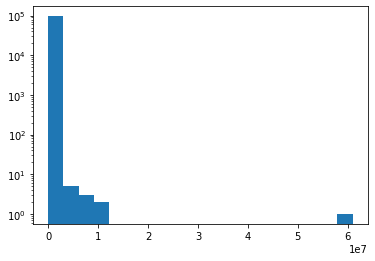

funded_amnt                                   16000
term                                      36 months
int_rate                                     0.1049
installment                                  519.97
grade                                             B
sub_grade                                        B2
emp_title                  Master Technical Trainer
emp_length                                10+ years
home_ownership                                  OWN
annual_inc                                    74133
verification_status                 Source Verified
loan_status                              Fully Paid
purpose                          debt_consolidation
dti                                           10.61
delinq_2yrs                                       2
inq_last_6mths                                    1
open_acc                                          7
pub_rec                                           0
revol_bal                                     12745
revol_util  

In [677]:
x = list(data['annual_inc'])
plt.hist(x,bins=20,log=True)
plt.show()
x.index(61000000)
data.iloc[18534]

In [678]:
data = data.dropna(axis = 0)
data = pd.DataFrame.reset_index(data)
data = data.drop(['index'],axis=1)
print(data)

       funded_amnt        term  int_rate  installment grade sub_grade  \
0          16000.0   60 months    0.1274       361.93     C        C1   
1          11875.0   36 months    0.1144       391.26     B        B4   
2          26000.0   60 months    0.1599       632.14     C        C5   
3          35000.0   36 months    0.1999      1300.55     D        D4   
4          14000.0   60 months    0.1274       316.69     C        C1   
...            ...         ...       ...          ...   ...       ...   
86799       3125.0   36 months    0.1349       106.04     C        C2   
86800      10400.0   36 months    0.1499       360.47     C        C4   
86801      30000.0   60 months    0.2149       819.90     D        D5   
86802      15000.0   36 months    0.1274       503.54     C        C1   
86803      15625.0   60 months    0.2869       493.03     F        F1   

                        emp_title emp_length home_ownership  annual_inc  \
0                  claims analyst  10+ years    

In [679]:
data.iloc[0:,:30].describe()

funded_amnt      int_rate   installment    annual_inc           dti  \
count  86804.000000  86804.000000  86804.000000  8.680400e+04  86804.000000   
mean   15223.291553      0.133202    460.512856  8.526953e+04     18.674012   
std     9459.419491      0.050959    285.514884  9.220739e+04      9.476349   
min     1000.000000      0.053200     30.120000  1.500000e+03     -1.000000   
25%     8000.000000      0.104900    251.580000  5.000000e+04     12.530000   
50%    12800.000000      0.127400    380.820000  7.080000e+04     18.120000   
75%    20000.000000      0.159900    617.460000  1.000000e+05     24.340000   
max    40000.000000      0.309900   1715.420000  9.522972e+06    844.800000   

        delinq_2yrs  inq_last_6mths      open_acc       pub_rec     revol_bal  \
count  86804.000000    86804.000000  86804.000000  86804.000000  8.680400e+04   
mean       0.358797        0.510218     12.064306      0.262154  1.763295e+04   
std        0.943371        0.808252      5.753568      0.717626  2.315996e+04   
min        0.000000        0.000000      1.000000      0.000000  0.000000e+00   
25%        0.000000        0.000000      8.000000      0.000000  6.669750e+03   
50%        0.000000        0.000000     11.000000      0.000000  1.207100e+04   
75%        0.000000        1.000000     15.000000      0.000000  2.119800e+04   
max       21.000000        5.000000     72.000000     61.000000  1.087664e+06   

        revol_util     total_acc     out_prncp   total_pymnt  total_rec_prncp  \
count  86804.00000  86804.000000  86804.000000  86804.000000     86804.000000   
mean       0.50426     24.439369   4106.614349  12411.568938      9777.298082   
std        0.23901     11.816075   5855.917464   8755.234320      7827.986406   
min        0.00000      3.000000      0.000000      0.000000         0.000000   
25%        0.32400     16.000000      0.000000   6087.042500      4236.030000   
50%        0.50000     23.000000   1357.315000  10127.120000      7350.000000   
75%        0.68500     31.000000   6498.872500  16484.917735     12675.387500   
max        1.58700    144.000000  30602.330000  60403.767370     40000.000000   

       total_rec_int  total_rec_late_fee    recoveries  \
count   86804.000000        86804.000000  86804.000000   
mean     2515.120690            1.997981    117.152193   
std      2385.652727           14.605246    668.686513   
min         0.000000            0.000000      0.000000   
25%       821.962500            0.000000      0.000000   
50%      1736.445000            0.000000      0.000000   
75%      3463.650000            0.000000      0.000000   
max     20403.770000          748.560000  39859.550000   

       collection_recovery_fee  last_pymnt_amnt   tot_coll_amt  
count             86804.000000     86804.000000   86804.000000  
mean                 20.409065      3907.960358     245.812958  
std                 118.709253      6748.139008    3629.645632  
min                   0.000000         0.000000       0.000000  
25%                   0.000000       314.480000       0.000000  
50%                   0.000000       614.965000       0.000000  
75%                   0.000000      4610.580000       0.000000  
max                7174.719000     41453.070000  932461.000000

In [682]:
grd = data['grade']
grd = list(grd)
grd[1:10]
counter = Counter(grd) #to show number of grades for each grade

from math import log10, floor
def round_sig(x, sig=2):
  return round(x, sig-int(floor(log10(abs(x))))-1)

for key, value in counter.items():
    counter[key] = round_sig(value/nrow)

print(counter) 
#31% from C, 27% from B, 14% from A, the rest D to G

Counter({'C': 0.31, 'B': 0.27, 'A': 0.14, 'D': 0.11, 'E': 0.046, 'F': 0.016, 'G': 0.005})


In [683]:
data["grade"] = data["grade"].astype('category')
data["grade"] = data["grade"].cat.codes
print(data["grade"][1:10])


1    1
2    2
3    3
4    2
5    0
6    1
7    2
8    2
9    0
Name: grade, dtype: int8


In [684]:
data["emp_length"] = data["emp_length"].astype('category')
data["emp_length"] = data["emp_length"].cat.reorder_categories(['< 1 year', '1 year','2 years','3 years','4 years','5 years','6 years','7 years','8 years','9 years','10+ years'])
data["emp_length"] = data["emp_length"].cat.codes
print(data["emp_length"][0:10])

0    10
1    10
2    10
3    10
4     4
5    10
6     1
7     0
8    10
9    10
Name: emp_length, dtype: int8


In [685]:
data["term"] = data["term"].str.strip()
data["term"] = data["term"].astype('category')
print(data["term"].dtypes)
data["term"] = data["term"].cat.reorder_categories(['36 months', '60 months'])
data["term"] = data["term"].cat.codes
print(data["term"][0:10])


category
0    1
1    0
2    1
3    0
4    1
5    0
6    0
7    0
8    0
9    0
Name: term, dtype: int8


In [686]:
print(np.unique(data["home_ownership"]))

home_ownership_dummy = pd.get_dummies(data['home_ownership'])
data['home_ownership_dummy_NONE'] = home_ownership_dummy['NONE']
data['home_ownership_dummy_ANY'] = home_ownership_dummy['ANY']
data['home_ownership_dummy_RENT'] = home_ownership_dummy['RENT']
data['home_ownership_MORTGAGE'] = home_ownership_dummy['MORTGAGE']
data['home_ownership_dummy_OWN'] = home_ownership_dummy['OWN']
data = data.drop(['home_ownership'],axis=1)

print(data.iloc[-5:])

['ANY' 'MORTGAGE' 'NONE' 'OWN' 'RENT']
       funded_amnt  term  int_rate  installment  grade sub_grade  \
86799       3125.0     0    0.1349       106.04      2        C2   
86800      10400.0     0    0.1499       360.47      2        C4   
86801      30000.0     1    0.2149       819.90      3        D5   
86802      15000.0     0    0.1274       503.54      2        C1   
86803      15625.0     1    0.2869       493.03      5        F1   

                        emp_title  emp_length  annual_inc verification_status  \
86799                         DSO           2     50500.0            Verified   
86800              Glaze Operator           5     26000.0     Source Verified   
86801     Teacher Department Head          10     60000.0            Verified   
86802      Senior Product Manager           2    110500.0     Source Verified   
86803  Certified Dietary Manager            1     34000.0     Source Verified   

       loan_status             purpose    dti  delinq_2yrs  inq_l

In [687]:
verification_status_dummy = pd.get_dummies(data['verification_status'])
data['verification_status_dummy_Not_verified'] = verification_status_dummy['Not Verified']
data['verification_status_dummy_Source_verified'] = verification_status_dummy['Source Verified']
data['verification_status_dummy_verified'] = verification_status_dummy['Verified']
data = data.drop(['verification_status'],axis=1)
print(verification_status_dummy)

       Not Verified  Source Verified  Verified
0                 1                0         0
1                 1                0         0
2                 0                1         0
3                 0                1         0
4                 1                0         0
...             ...              ...       ...
86799             0                0         1
86800             0                1         0
86801             0                0         1
86802             0                1         0
86803             0                1         0

[86804 rows x 3 columns]


In [688]:
loan_status_dummy = pd.get_dummies(data['loan_status'])
print(loan_status_dummy)
data['loan_status_dummy_chargedoff'] = loan_status_dummy['Charged Off']
data['loan_status_dummy_current'] = loan_status_dummy['Current']
data['loan_status_dummy_default'] = loan_status_dummy['Default']
data['loan_status_dummy_fullypaid'] = loan_status_dummy['Fully Paid']
data['loan_status_dummy_ingraceperiod'] = loan_status_dummy['In Grace Period']
data['loan_status_dummy_late16-30'] = loan_status_dummy['Late (16-30 days)']
data['loan_status_dummy_late31-120'] = loan_status_dummy['Late (31-120 days)']
data = data.drop(['loan_status'],axis=1)

       Charged Off  Current  Default  Fully Paid  In Grace Period  \
0                0        0        0           1                0   
1                0        1        0           0                0   
2                0        1        0           0                0   
3                0        1        0           0                0   
4                0        1        0           0                0   
...            ...      ...      ...         ...              ...   
86799            0        1        0           0                0   
86800            0        0        0           1                0   
86801            0        0        0           1                0   
86802            0        0        0           1                0   
86803            1        0        0           0                0   

       Late (16-30 days)  Late (31-120 days)  
0                      0                   0  
1                      0                   0  
2                      0      

In [689]:
purpose_dummy = pd.get_dummies(data['purpose'])
print(purpose_dummy)
data['purpose_dummy_car'] = purpose_dummy['car']
data['purpose_dummy_credit_card'] = purpose_dummy['credit_card']
data['purpose_dummy_debt_consolidation'] = purpose_dummy['debt_consolidation']
data['purpose_dummy_home_improvement'] = purpose_dummy['home_improvement']
data['purpose_dummy_house'] = purpose_dummy['house']
data['purpose_dummy_major_purchase'] = purpose_dummy['major_purchase']
data['purpose_dummy_medical'] = purpose_dummy['medical']
data['purpose_dummy_moving'] = purpose_dummy['moving']
data['purpose_dummy_other'] = purpose_dummy['other']
data['purpose_dummy_renewable_energy'] = purpose_dummy['renewable_energy']
data['purpose_dummy_small_business'] = purpose_dummy['small_business']
data['purpose_dummy_vacation'] = purpose_dummy['vacation']
data = data.drop(['purpose'],axis=1)


       car  credit_card  debt_consolidation  home_improvement  house  \
0        0            0                   1                 0      0   
1        0            0                   0                 1      0   
2        0            0                   1                 0      0   
3        0            0                   1                 0      0   
4        0            1                   0                 0      0   
...    ...          ...                 ...               ...    ...   
86799    0            0                   0                 0      0   
86800    0            0                   1                 0      0   
86801    0            0                   1                 0      0   
86802    0            1                   0                 0      0   
86803    0            0                   1                 0      0   

       major_purchase  medical  moving  other  renewable_energy  \
0                   0        0       0      0                 0   
1

In [0]:
data = data.drop(['sub_grade'],axis=1) # we drop subgrade because we only want to look at grades

In [0]:
data = data.drop(['emp_title'],axis=1) #emp_title have too many levels

After cleaning the data, now let us look at how we implement T-SNE onto the data itself. Before that, we will use auto-encoders to shrink the dimension of the dataset first then implement T-SNE to visualise the data. **/ need to visualise variables as well!!!**

In [0]:
y = data['grade'][:3000]
X = data.drop(['grade'], axis=1)[:3000]
#we have 6 categorical variables
X_non_numeric = X[['term','emp_length','verification_status_dummy_Not_verified','verification_status_dummy_Source_verified','verification_status_dummy_verified','loan_status_dummy_chargedoff','loan_status_dummy_current','loan_status_dummy_default','loan_status_dummy_fullypaid','loan_status_dummy_ingraceperiod','loan_status_dummy_late16-30','loan_status_dummy_late31-120','purpose_dummy_car','purpose_dummy_credit_card','purpose_dummy_debt_consolidation','purpose_dummy_home_improvement','purpose_dummy_house','purpose_dummy_major_purchase','purpose_dummy_medical','purpose_dummy_moving','purpose_dummy_other','purpose_dummy_renewable_energy','purpose_dummy_small_business','purpose_dummy_vacation','home_ownership_dummy_NONE','home_ownership_dummy_ANY','home_ownership_dummy_RENT','home_ownership_MORTGAGE','home_ownership_dummy_OWN']]
X_numeric = X.drop(['term','emp_length','verification_status_dummy_Not_verified','verification_status_dummy_Source_verified','verification_status_dummy_verified','loan_status_dummy_chargedoff','loan_status_dummy_current','loan_status_dummy_default','loan_status_dummy_fullypaid','loan_status_dummy_ingraceperiod','loan_status_dummy_late16-30','loan_status_dummy_late31-120','purpose_dummy_car','purpose_dummy_credit_card','purpose_dummy_debt_consolidation','purpose_dummy_home_improvement','purpose_dummy_house','purpose_dummy_major_purchase','purpose_dummy_medical','purpose_dummy_moving','purpose_dummy_other','purpose_dummy_renewable_energy','purpose_dummy_small_business','purpose_dummy_vacation','home_ownership_dummy_NONE','home_ownership_dummy_ANY','home_ownership_dummy_RENT','home_ownership_MORTGAGE','home_ownership_dummy_OWN'],axis=1)

In [0]:
y2 = data['grade'][3001:3501]
X2 = data.drop(['grade'], axis=1)
X2 = X2[3001:3500]
#we have 6 categorical variables
X2_non_numeric = X2[['term','verification_status_dummy_Not_verified','verification_status_dummy_Source_verified','verification_status_dummy_verified','loan_status_dummy_chargedoff','loan_status_dummy_current','loan_status_dummy_default','loan_status_dummy_fullypaid','loan_status_dummy_ingraceperiod','loan_status_dummy_late16-30','loan_status_dummy_late31-120','purpose_dummy_car','purpose_dummy_credit_card','purpose_dummy_debt_consolidation','purpose_dummy_home_improvement','purpose_dummy_house','purpose_dummy_major_purchase','purpose_dummy_medical','purpose_dummy_moving','purpose_dummy_other','purpose_dummy_renewable_energy','purpose_dummy_small_business','purpose_dummy_vacation','home_ownership_dummy_NONE','home_ownership_dummy_ANY','home_ownership_dummy_RENT','home_ownership_MORTGAGE','home_ownership_dummy_OWN']]
X2_numeric = X2.drop(['term','verification_status_dummy_Not_verified','verification_status_dummy_Source_verified','verification_status_dummy_verified','loan_status_dummy_chargedoff','loan_status_dummy_current','loan_status_dummy_default','loan_status_dummy_fullypaid','loan_status_dummy_ingraceperiod','loan_status_dummy_late16-30','loan_status_dummy_late31-120','purpose_dummy_car','purpose_dummy_credit_card','purpose_dummy_debt_consolidation','purpose_dummy_home_improvement','purpose_dummy_house','purpose_dummy_major_purchase','purpose_dummy_medical','purpose_dummy_moving','purpose_dummy_other','purpose_dummy_renewable_energy','purpose_dummy_small_business','purpose_dummy_vacation','home_ownership_dummy_NONE','home_ownership_dummy_ANY','home_ownership_dummy_RENT','home_ownership_MORTGAGE','home_ownership_dummy_OWN'],axis=1)

In [0]:
scaler = preprocessing.StandardScaler().fit(X2_numeric)
X2_numeric_scaled = preprocessing.scale(X2_numeric)

X2_numeric_scaled = pd.DataFrame(X2_numeric_scaled,columns = X2_numeric.columns)
#print(X2_numeric_scaled)
X2_non_numeric = pd.DataFrame(X2_non_numeric,columns = X2_non_numeric.columns)
X2_non_numeric =  pd.DataFrame.reset_index(X2_non_numeric)
X2_non_numeric = X2_non_numeric.drop(['index'],axis=1)
#print(X2_non_numeric)
X2_scaled = pd.concat([X2_numeric_scaled, X2_non_numeric], axis=1, sort=False)
y2 =  pd.Series.reset_index(y2)
y2 = y2.drop(['index'],axis=1)
#X_scaled = X_numeric_scaled
#print(X2_scaled,y2)

In [696]:
scaler = preprocessing.StandardScaler().fit(X_numeric)
X_numeric_scaled = preprocessing.scale(X_numeric)

X_numeric_scaled = pd.DataFrame(X_numeric_scaled,columns = X_numeric.columns)

#print(X_numeric_scaled)
X_non_numeric = pd.DataFrame(X_non_numeric,columns = X_non_numeric.columns)

#print(X_non_numeric)
X_scaled = pd.concat([X_numeric_scaled, X_non_numeric], axis=1, sort=False)
#X_scaled = X_numeric_scaled
print(X_scaled,y)

      funded_amnt  int_rate  installment  annual_inc       dti  delinq_2yrs  \
0        0.135265 -0.030000    -0.282026    0.241494 -1.097612    -0.399341   
1       -0.297785 -0.299157    -0.179254   -0.179419  1.730491    -0.399341   
2        1.185083  0.642892     0.664787   -0.196256  0.219365    -0.399341   
3        2.129919  1.471066     3.006887   -0.039115 -0.841982     0.697749   
4       -0.074699 -0.030000    -0.440546   -0.263602 -0.105295    -0.399341   
...           ...       ...          ...         ...       ...          ...   
2995     2.129919  0.435848     2.700533   -0.041921 -0.533501    -0.399341   
2996    -0.704590 -0.961696    -0.668691   -0.158239  0.471759    -0.399341   
2997    -0.473630  0.435848    -0.700122   -0.291663 -0.226099    -0.399341   
2998    -0.536619 -1.566263    -0.537186    0.072006 -0.945528    -0.399341   
2999    -1.019535 -1.566263    -1.022594   -0.067176 -0.045972    -0.399341   

      inq_last_6mths  open_acc   pub_rec  revol_bal

In [697]:
#X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train = X_scaled
y_train = y
X_test = X2_scaled
y_test = y2
print('X train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print(X_train,y_train)

X train shape: (3000, 87)
3000 train samples
499 test samples
      funded_amnt  int_rate  installment  annual_inc       dti  delinq_2yrs  \
0        0.135265 -0.030000    -0.282026    0.241494 -1.097612    -0.399341   
1       -0.297785 -0.299157    -0.179254   -0.179419  1.730491    -0.399341   
2        1.185083  0.642892     0.664787   -0.196256  0.219365    -0.399341   
3        2.129919  1.471066     3.006887   -0.039115 -0.841982     0.697749   
4       -0.074699 -0.030000    -0.440546   -0.263602 -0.105295    -0.399341   
...           ...       ...          ...         ...       ...          ...   
2995     2.129919  0.435848     2.700533   -0.041921 -0.533501    -0.399341   
2996    -0.704590 -0.961696    -0.668691   -0.158239  0.471759    -0.399341   
2997    -0.473630  0.435848    -0.700122   -0.291663 -0.226099    -0.399341   
2998    -0.536619 -1.566263    -0.537186    0.072006 -0.945528    -0.399341   
2999    -1.019535 -1.566263    -1.022594   -0.067176 -0.045972    -0.

In [0]:
X_subset = X_train
y_subset = y_train

AUTOENCODERS - TSNE


In [699]:
# reduce to 30 features
encoding_dim = 30

input_df = Input(shape=(X_subset.shape[1],))
encoded = Dense(40, activation='relu')(input_df)
encoded = Dense(encoding_dim, activation='relu')(encoded) #bottleneck
decoded = Dense(40, activation='sigmoid')(encoded)
decoded = Dense(X_subset.shape[1], activation='sigmoid')(decoded)
# encoder
autoencoder = Model(input_df, decoded)

# intermediate result
encoder = Model(input_df, encoded)

autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
time_start = time.time()

autoencoder.fit(X_subset, X_subset,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(X_test, X_test))

print('Autoencoders done! Time elapsed: {} seconds'.format(time.time()-time_start))

encoded_X_train = encoder.predict(X_subset)
encoded_X_test = encoder.predict(X_test)

Train on 3000 samples, validate on 499 samples
Epoch 1/100
3000/3000 [==============================] - 1s 419us/step - loss: 1.3804 - val_loss: 0.8441
Epoch 2/100
3000/3000 [==============================] - 0s 21us/step - loss: 1.2707 - val_loss: 0.7852
Epoch 3/100
3000/3000 [==============================] - 0s 23us/step - loss: 1.2107 - val_loss: 0.7536
Epoch 4/100
3000/3000 [==============================] - 0s 25us/step - loss: 1.1857 - val_loss: 0.7378
Epoch 5/100
3000/3000 [==============================] - 0s 25us/step - loss: 1.1742 - val_loss: 0.7294
Epoch 6/100
3000/3000 [==============================] - 0s 23us/step - loss: 1.1676 - val_loss: 0.7240
Epoch 7/100
3000/3000 [==============================] - 0s 23us/step - loss: 1.1630 - val_loss: 0.7202
Epoch 8/100
3000/3000 [==============================] - 0s 23us/step - loss: 1.1591 - val_loss: 0.7172
Epoch 9/100
3000/3000 [==============================] - 0s 21us/step - loss: 1.1553 - val_loss: 0.7145
Epoch 10/100
300

In [701]:
print(encoded_X_train.shape)

# Subset first 1k data points to visualize    
x_subset_AE = encoded_X_train
y_subset_AE = y_subset

# print(x_subset)
print(x_subset_AE)

(3000, 30)
[[12.21482   12.941056  10.443492  ...  0.         0.         0.       ]
 [ 7.261407  12.580981  11.072246  ...  0.         2.1786983  0.       ]
 [16.498217   7.8071785  4.423491  ...  0.         0.         0.       ]
 ...
 [ 6.892465   5.7068086  8.872824  ...  0.         2.0657694  0.       ]
 [11.979064   7.796233  10.682141  ...  0.         4.748433   0.       ]
 [ 6.222459   2.3956594  9.030771  ...  0.         6.5878105  0.       ]]


In [702]:
import time
time_start = time.time()

RS=12
AE_tsne = TSNE(random_state=RS, method='exact',perplexity = 30,verbose = 2).fit_transform(x_subset_AE)

print('AE t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 3.941495
[t-SNE] Iteration 50: error = 83.5381368, gradient norm = 0.0231804 (50 iterations in 11.445s)
[t-SNE] Iteration 100: error = 77.6510632, gradient norm = 0.0009343 (50 iterations in 11.441s)
[t-SNE] Iteration 150: error = 77.5947135, gradient norm = 0.0000972 (50 iterations in 11.322s)
[t-SNE] Iteration 200: error = 77.5935328, gradient norm = 0.0001009 (50 iterations in 11.321s)
[t-SNE] Iteration 250: error = 77.5911152, gradient norm = 0.0002329 (50 iterations in 11.432s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.591115
[t-SNE] Iteration 300: error = 2.0500911, gradient norm = 0.0012919 (50 iterations in 11.282s)
[t-SNE] Iteration 350: error = 1.7841246, gradient norm = 0.0004608 (50 iteration

kmeans for AE-tsne

In [0]:
palette = np.array(sns.color_palette("hls", 7))
AE_tsne_df = pd.DataFrame(columns=['tsne1', 'tsne2','y_subset'])
AE_tsne_df['tsne1'] = AE_tsne[:, 0]
AE_tsne_df['tsne2'] = AE_tsne[:, 1]
AE_tsne_df['y_subset'] = y_subset_AE
AE_tsne_df = AE_tsne_df.sort_values(by=['y_subset'])

[1 1 1 ... 0 1 0]


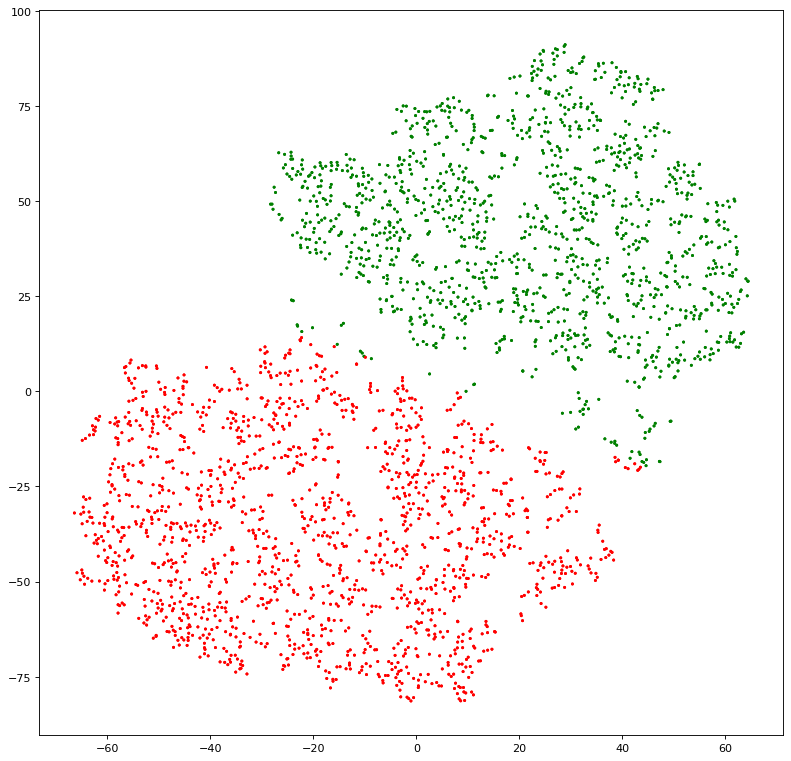

In [704]:
km = KMeans(n_clusters=2, init='random',n_init=10, max_iter=300,tol=1e-04,random_state = 2)
X_kmAE = pd.DataFrame(columns=['tsne1', 'tsne2'])
X_kmAE['tsne1'] = AE_tsne[:, 0]
X_kmAE['tsne2'] = AE_tsne[:, 1]

y_kmAE = km.fit_predict(X_kmAE)
print(y_kmAE)

AE_tsne_df['kmeans_label'] = y_kmAE

colors = ['red','green']
label = y_kmAE
red_patch = mpatches.Patch(color='red', label='0')
green_patch = mpatches.Patch(color='green', label='1')


figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
for color in colors:
    plt.scatter(X_kmAE.iloc[:, 0],X_kmAE.iloc[:, 1],lw=0, c=label,cmap=pcolors.ListedColormap(colors),s=7)

Text(0.5, 1.0, 'T-SNE with Autoencoders')

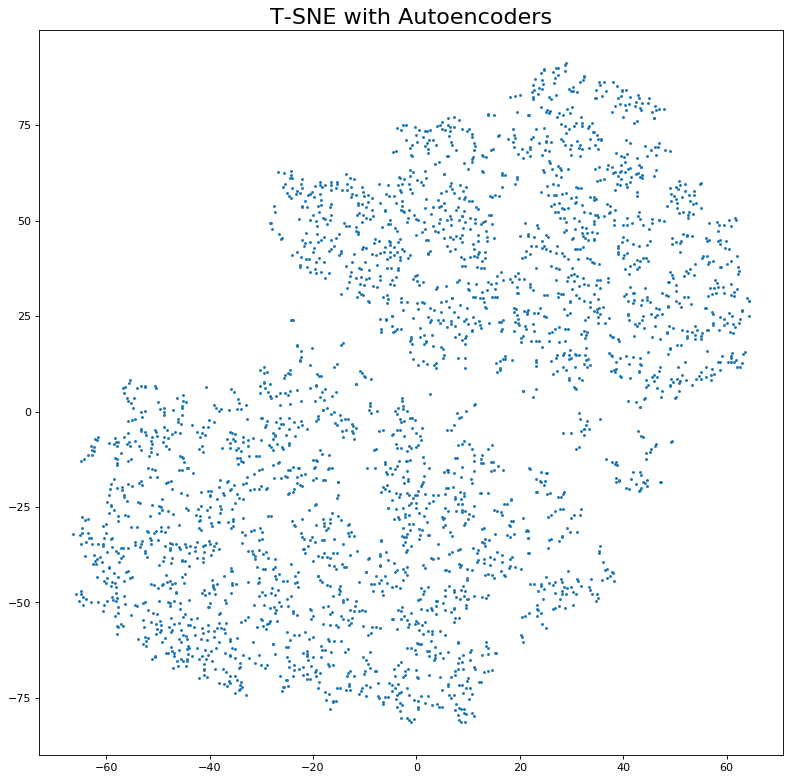

In [705]:
colors = ['red','green','blue','purple','orange','violet','cyan']
label = AE_tsne_df.iloc[:,2]
c= [colors[i] for i in label.to_numpy()]
red_patch = mpatches.Patch(color='red', label='A')
green_patch = mpatches.Patch(color='green', label='B')
blue_patch = mpatches.Patch(color='blue', label='C')
purple_patch = mpatches.Patch(color='purple', label='D')
orange_patch = mpatches.Patch(color='orange', label='E')
violet_patch = mpatches.Patch(color='violet', label='F')
cyan_patch = mpatches.Patch(color='cyan', label='G')
figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# for color in colors:
#     plt.scatter(AE_tsne_df.iloc[:, 0], AE_tsne_df.iloc[:, 1],lw=0, c=label,cmap=pcolors.ListedColormap(colors),s=7)

# ax = plt.subplot(111)
# ax.legend(handles=[red_patch,green_patch,blue_patch,purple_patch,orange_patch,violet_patch,cyan_patch])
# plt.title('T-SNE with Autoencoders',{'fontsize': 20})
plt.scatter(AE_tsne_df.iloc[:, 0], AE_tsne_df.iloc[:, 1],lw=0, s=7)
plt.title('T-SNE with Autoencoders',{'fontsize': 20})

In [724]:
AE_summary = pd.DataFrame(X[:3000])
AE_summary['kmeans'] = y_kmAE
AE_summary_1= AE_summary[AE_summary['kmeans'] == 1]
AE_summary_0= AE_summary[AE_summary['kmeans'] == 0]
table1 = (AE_summary_1.describe())
table1.round(decimals=3)

funded_amnt      term  int_rate  installment  emp_length   annual_inc  \
count     1398.000  1398.000  1398.000     1398.000    1398.000     1398.000   
mean     15590.719     0.278     0.128      463.198       9.677    98381.726   
std       9776.675     0.448     0.049      290.399       0.853   255193.245   
min       1000.000     0.000     0.053       31.340       4.000    16959.000   
25%       8000.000     0.000     0.082      251.580      10.000    56000.000   
50%      13012.500     0.000     0.115      389.010      10.000    76000.000   
75%      21000.000     1.000     0.150      611.690      10.000   106000.000   
max      40000.000     1.000     0.310     1445.900      10.000  9300086.000   

            dti  delinq_2yrs  inq_last_6mths  open_acc   pub_rec   revol_bal  \
count  1398.000     1398.000        1398.000  1398.000  1398.000    1398.000   
mean     18.447        0.393           0.534    12.589     0.270   19943.966   
std       8.728        0.950           0.828     5.955     0.672   28424.909   
min       0.330        0.000           0.000     2.000     0.000       0.000   
25%      12.125        0.000           0.000     9.000     0.000    7274.000   
50%      17.990        0.000           0.000    12.000     0.000   13262.000   
75%      24.210        0.000           1.000    15.000     0.000   23876.000   
max      81.330        9.000           5.000    51.000     6.000  539283.000   

       revol_util  total_acc  out_prncp  total_pymnt  total_rec_prncp  \
count    1398.000   1398.000   1398.000     1398.000         1398.000   
mean        0.499     25.632   4821.041    12101.639         9569.381   
std         0.236     11.339   6335.146     8565.347         7699.248   
min         0.000      4.000      0.000        0.000            0.000   
25%         0.330     18.000      0.000     5959.913         4234.882   
50%         0.492     24.000   2200.045    10059.840         7088.595   
75%         0.674     32.000   7775.002    15687.788        12000.000   
max         1.083     90.000  28261.690    45999.853        40000.000   

       total_rec_int  total_rec_late_fee  recoveries  collection_recovery_fee  \
count       1398.000            1398.000    1398.000                 1398.000   
mean        2443.057               1.340      87.861                   15.751   
std         2279.924              10.261     610.392                  109.801   
min            0.000               0.000       0.000                    0.000   
25%          801.930               0.000       0.000                    0.000   
50%         1719.430               0.000       0.000                    0.000   
75%         3360.668               0.000       0.000                    0.000   
max        17209.690             206.050   14848.000                 2672.640   

       last_pymnt_amnt  tot_coll_amt  tot_cur_bal  open_acc_6m  open_act_il  \
count         1398.000      1398.000     1398.000     1398.000     1398.000   
mean          3780.705       321.903   175420.604        0.925        2.674   
std           7001.055      2811.578   196764.515        1.150        2.621   
min              0.000         0.000      836.000        0.000        0.000   
25%            308.730         0.000    36169.500        0.000        1.000   
50%            557.015         0.000   116780.500        1.000        2.000   
75%           3768.132         0.000   253230.000        1.000        3.000   
max          40305.070     77958.000  1989015.000        9.000       29.000   

       open_il_12m  open_il_24m  mths_since_rcnt_il  total_bal_il  \
count     1398.000     1398.000            1398.000      1398.000   
mean         0.627        1.548              21.646     34867.154   
std          0.813        1.383              25.539     43271.858   
min          0.000        0.000               1.000         0.000   
25%          0.000        1.000               7.000      9972.750   
50%          0.000        1.000              14.000

In [725]:
table0 = (AE_summary_0.describe())
table0.round(decimals=3)

funded_amnt      term  int_rate  installment  emp_length  annual_inc  \
count     1602.000  1602.000  1602.000     1602.000    1602.000    1602.000   
mean     13944.320     0.226     0.130      424.283       3.096   77010.761   
std       9238.653     0.418     0.047      279.867       2.123   49545.878   
min       1000.000     0.000     0.053       32.950       0.000    8000.000   
25%       7000.000     0.000     0.105      224.062       2.000   45000.000   
50%      12000.000     0.000     0.127      341.925       3.000   65000.000   
75%      19075.000     0.000     0.160      549.070       5.000   95000.000   
max      40000.000     1.000     0.309     1542.980       9.000  650000.000   

            dti  delinq_2yrs  inq_last_6mths  open_acc   pub_rec   revol_bal  \
count  1602.000     1602.000        1602.000  1602.000  1602.000    1602.000   
mean     18.464        0.338           0.488    11.336     0.225   15436.095   
std       9.726        0.877           0.778     5.442     0.602   19750.703   
min       0.630        0.000           0.000     2.000     0.000       0.000   
25%      12.015        0.000           0.000     7.000     0.000    5600.250   
50%      17.370        0.000           0.000    10.000     0.000   10742.000   
75%      23.708        0.000           1.000    14.000     0.000   18476.500   
max     128.340       10.000           5.000    41.000     5.000  268398.000   

       revol_util  total_acc  out_prncp  total_pymnt  total_rec_prncp  \
count    1602.000   1602.000   1602.000     1602.000         1602.000   
mean        0.501     22.242   4148.063    10817.547         8504.856   
std         0.239     11.423   5792.199     8091.571         7177.688   
min         0.000      3.000      0.000        0.000            0.000   
25%         0.325     14.000      0.000     5332.076         3655.303   
50%         0.502     20.000   1813.685     8336.904         6122.410   
75%         0.676     29.000   6200.880    14126.720        10650.000   
max         1.200     79.000  28906.130    46181.405        40000.000   

       total_rec_int  total_rec_late_fee  recoveries  collection_recovery_fee  \
count       1602.000            1602.000    1602.000                 1602.000   
mean        2212.066               1.803      98.822                   17.446   
std         2166.937              10.824     519.590                   92.528   
min            0.000               0.000       0.000                    0.000   
25%          706.510               0.000       0.000                    0.000   
50%         1503.055               0.000       0.000                    0.000   
75%         2970.910               0.000       0.000                    0.000   
max        17265.470             195.600    8203.870                 1476.697   

       last_pymnt_amnt  tot_coll_amt  tot_cur_bal  open_acc_6m  open_act_il  \
count         1602.000      1602.000     1602.000     1602.000      1602.00   
mean          3090.917       217.644   133526.875        0.882         3.36   
std           5829.351      1256.116   151436.362        1.050         3.51   
min              0.000         0.000       74.000        0.000         0.00   
25%            276.810         0.000    28685.000        0.000         1.00   
50%            499.480         0.000    67442.000        1.000         2.00   
75%           3071.092         0.000   196074.500        1.000         4.00   
max          36823.200     37642.000  1398656.000        6.000        27.00   

       open_il_12m  open_il_24m  mths_since_rcnt_il  total_bal_il  \
count     1602.000     1602.000            1602.000      1602.000   
mean         0.587        1.461              22.503     37801.979   
std          0.804        1.447              26.677     47501.996   
min          0.000        0.000               0.000         0.000   
25%          0.000        0.000               8.000     11447.750   
50%          0.000        1.000              15.000     2463

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


Text(0.5, 1.0, 'T-SNE with Autoencoders')

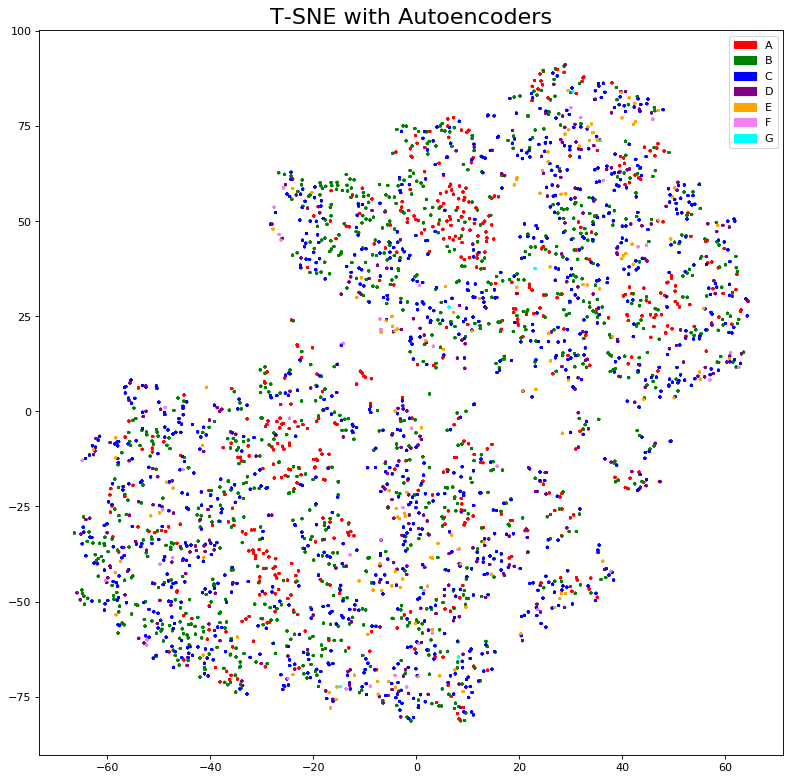

In [708]:
colors = ['red','green','blue','purple','orange','violet','cyan']
label = AE_tsne_df.iloc[:,2]
c= [colors[i] for i in label.to_numpy()]
red_patch = mpatches.Patch(color='red', label='A')
green_patch = mpatches.Patch(color='green', label='B')
blue_patch = mpatches.Patch(color='blue', label='C')
purple_patch = mpatches.Patch(color='purple', label='D')
orange_patch = mpatches.Patch(color='orange', label='E')
violet_patch = mpatches.Patch(color='violet', label='F')
cyan_patch = mpatches.Patch(color='cyan', label='G')
figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
for color in colors:
    plt.scatter(AE_tsne_df.iloc[:, 0], AE_tsne_df.iloc[:, 1],lw=0, c=label,cmap=pcolors.ListedColormap(colors),s=7)

ax = plt.subplot(111)
ax.legend(handles=[red_patch,green_patch,blue_patch,purple_patch,orange_patch,violet_patch,cyan_patch])
plt.title('T-SNE with Autoencoders',{'fontsize': 20})

In [709]:
def distance_metric(df):
  norms = []
  for r in np.unique(df[df.columns[2]]):
    components = df[df[df.columns[2]] == r][df.columns[:2]]
    center = components.mean()
    norms.append(np.linalg.norm(components - center))
  return sum(norms)
df_1 = AE_tsne_df[AE_tsne_df['kmeans_label']==0]
df_2 = AE_tsne_df[AE_tsne_df['kmeans_label']==1]
distance_metric(df_1) + distance_metric(df_2)

9723.44474029541

PCA done! Time elapsed: 6.079673767089844e-05 seconds
Variance explained per principal component: [0.19298372 0.11676844 0.0794043  0.05698336]


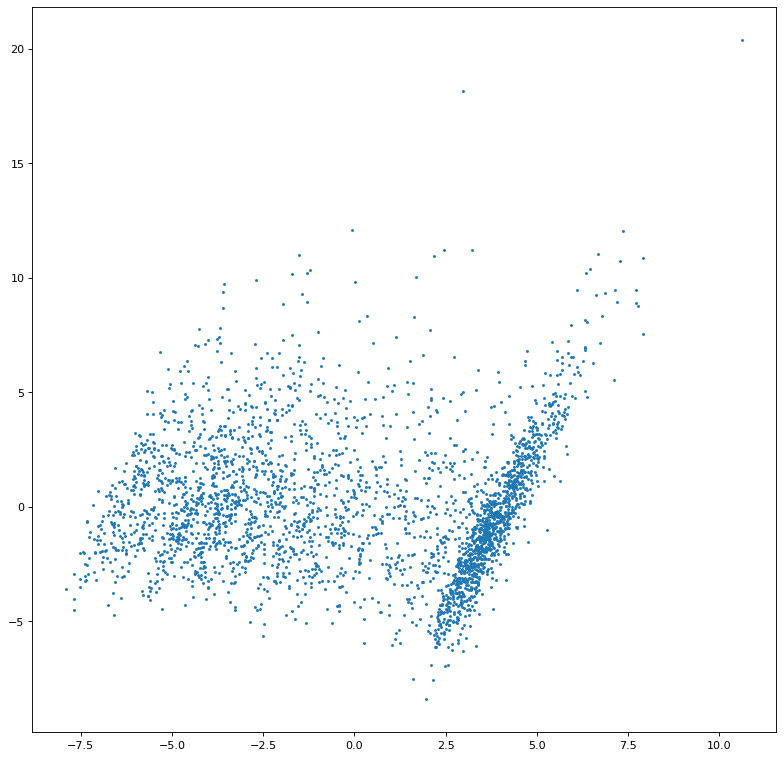

In [727]:
pca = PCA(n_components=4)
pca_result = pca.fit_transform(X_subset)
time_start = time.time()
print('PCA done! Time elapsed: {} seconds'.format(time.time() - time_start))

pca_df = pd.DataFrame(columns=['pca1', 'pca2', 'pca3', 'pca4'])

pca_df['pca1'] = pca_result[:, 0]
pca_df['pca2'] = pca_result[:, 1]
pca_df['pca3'] = pca_result[:, 2]
pca_df['pca4'] = pca_result[:, 3]

print('Variance explained per principal component: {}'.format(pca.explained_variance_ratio_))

top_two_comp = pca_df[['pca1', 'pca2']]  # taking first and second principal component

colors = ['red','green','blue','purple','orange','violet','cyan']
label = y_subset
c= [colors[i] for i in label.to_numpy()]
red_patch = mpatches.Patch(color='red', label='A')
green_patch = mpatches.Patch(color='green', label='B')
blue_patch = mpatches.Patch(color='blue', label='C')
purple_patch = mpatches.Patch(color='purple', label='D')
orange_patch = mpatches.Patch(color='orange', label='E')
violet_patch = mpatches.Patch(color='violet', label='F')
cyan_patch = mpatches.Patch(color='cyan', label='G')

figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# for color in colors:
#     plt.scatter(pca_df.iloc[:, 0], pca_df.iloc[:, 1],lw=0, c=label,cmap=pcolors.ListedColormap(colors),s=7)

# ax = plt.subplot(111)
# ax.legend(handles=[red_patch,green_patch,blue_patch,purple_patch,orange_patch,violet_patch,cyan_patch])
plt.scatter(pca_df.iloc[:, 0], pca_df.iloc[:, 1],lw=0,s=7)


In [711]:
time_start = time.time()

pca_30 = PCA(n_components=30, random_state= 123)
pca_result_30 = pca_30.fit_transform(X_subset)

print('PCA with 30 components done! Time elapsed: {} seconds'.format(time.time()-time_start))

print('Cumulative variance explained by 30 principal components: {}'.format(np.sum(pca_30.explained_variance_ratio_)))

PCA with 30 components done! Time elapsed: 0.05011725425720215 seconds
Cumulative variance explained by 30 principal components: 0.9046155672386366


pca-tsne (perplexity = 50)


In [712]:
import time
time_start = time.time()

RS=12
pca_tsne = TSNE(random_state=RS, method='exact',perplexity = 30,verbose = 2).fit_transform(pca_result_30)

print('PCA t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
palette = np.array(sns.color_palette("hls", 7))
pca_tsne_df = pd.DataFrame(columns=['tsne1', 'tsne2','y_subset'])
pca_tsne_df['tsne1'] = pca_tsne[:, 0]
pca_tsne_df['tsne2'] = pca_tsne[:, 1]
pca_tsne_df['y_subset'] = y_subset
pca_tsne_df = pca_tsne_df.sort_values(by=['y_subset'])

km = KMeans(n_clusters=2, init='random',n_init=10, max_iter=300,tol=1e-04, random_state=0)
X_km_pca = pd.DataFrame(columns=['tsne1', 'tsne2'])
X_km_pca['tsne1'] = pca_tsne[:, 0]
X_km_pca['tsne2'] = pca_tsne[:, 1]

y_km_pca = km.fit_predict(X_km_pca)
print(y_km_pca)

pca_tsne_df['kmeans_label'] = y_km_pca

def distance_metric(df):
  norms = []
  for r in np.unique(df[df.columns[2]]):
    components = df[df[df.columns[2]] == r][df.columns[:2]]
    center = components.mean()
    norms.append(np.linalg.norm(components - center))
  return sum(norms)

pca_df_1 = pca_tsne_df[pca_tsne_df['kmeans_label']==0]
pca_df_2 = pca_tsne_df[pca_tsne_df['kmeans_label']==1]

distance_metric(pca_df_1) + distance_metric(pca_df_2)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 2.003532
[t-SNE] Iteration 50: error = 81.5755329, gradient norm = 0.0090580 (50 iterations in 11.059s)
[t-SNE] Iteration 100: error = 81.5473561, gradient norm = 0.0145604 (50 iterations in 11.084s)
[t-SNE] Iteration 150: error = 78.8351422, gradient norm = 0.0053114 (50 iterations in 11.070s)
[t-SNE] Iteration 200: error = 78.8245163, gradient norm = 0.0088334 (50 iterations in 11.108s)
[t-SNE] Iteration 250: error = 78.8240151, gradient norm = 0.0061962 (50 iterations in 11.014s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.824015
[t-SNE] Iteration 300: error = 2.4696507, gradient norm = 0.0015070 (50 iterations in 11.102s)
[t-SNE] Iteration 350: error = 2.2108252, gradient norm = 0.0005274 (50 iteration

9257.16226196289

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


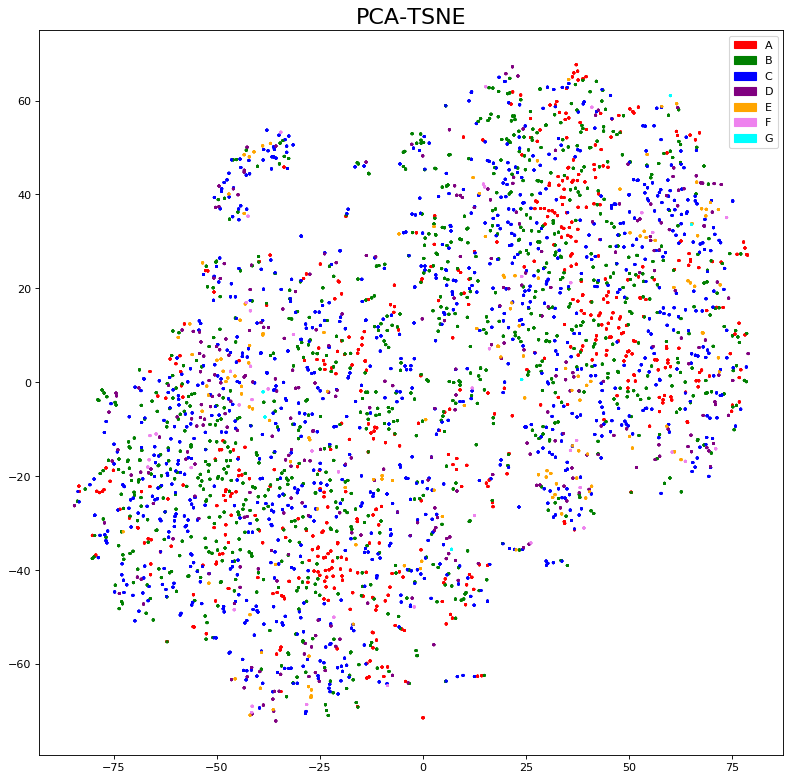

In [713]:
colors = ['red','green','blue','purple','orange','violet','cyan']
label = pca_tsne_df.iloc[:,2]
c= [colors[i] for i in label.to_numpy()]
red_patch = mpatches.Patch(color='red', label='A')
green_patch = mpatches.Patch(color='green', label='B')
blue_patch = mpatches.Patch(color='blue', label='C')
purple_patch = mpatches.Patch(color='purple', label='D')
orange_patch = mpatches.Patch(color='orange', label='E')
violet_patch = mpatches.Patch(color='violet', label='F')
cyan_patch = mpatches.Patch(color='cyan', label='G')

figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
for color in colors:
    plt.scatter(pca_tsne_df.iloc[:, 0], pca_tsne_df.iloc[:, 1],lw=0, c=label,cmap=pcolors.ListedColormap(colors),s=7)

ax = plt.subplot(111)
plt.title('PCA-TSNE',{'fontsize': 20})
ax.legend(handles=[red_patch,green_patch,blue_patch,purple_patch,orange_patch,violet_patch,cyan_patch])

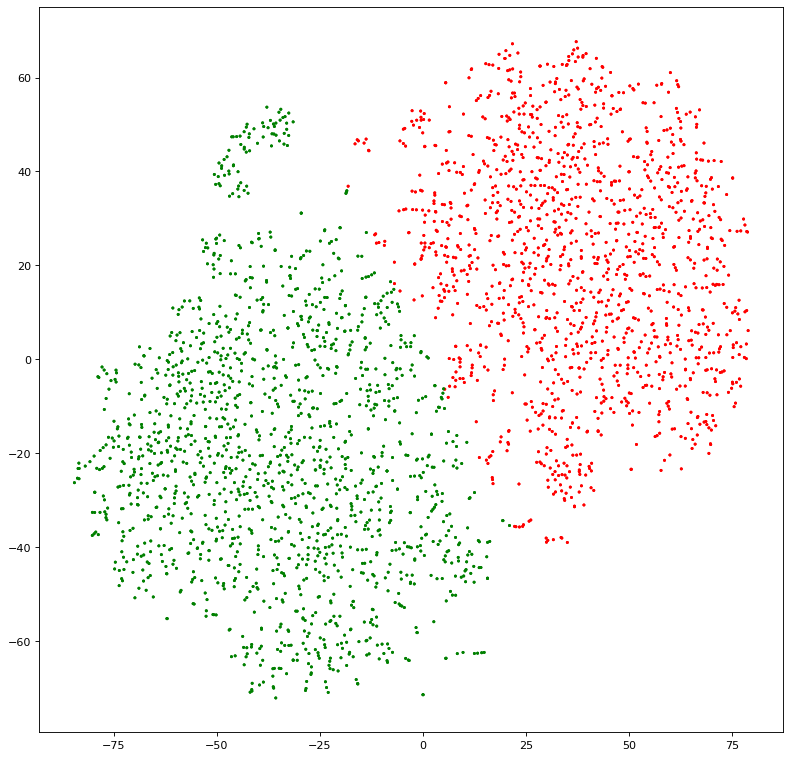

In [714]:
colors = ['red','green']
label = y_km_pca
red_patch = mpatches.Patch(color='red', label='0')
green_patch = mpatches.Patch(color='green', label='1')

figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
for color in colors:
    plt.scatter(X_km_pca.iloc[:, 0],X_km_pca.iloc[:, 1],lw=0, c=label,cmap=pcolors.ListedColormap(colors),s=7)

TSNE

In [715]:
import time
time_start = time.time()

RS=12
fashion_pca_tsne = TSNE(random_state=RS, method='exact',verbose =2,perplexity = 40).fit_transform(X_subset)

print('Exact t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
palette = np.array(sns.color_palette("hls", 7))
tsne_df = pd.DataFrame(columns=['tsne1', 'tsne2','y_subset'])
tsne_df['tsne1'] = fashion_pca_tsne[:, 0]
tsne_df['tsne2'] = fashion_pca_tsne[:, 1]
tsne_df['y_subset'] = y_subset
tsne_df = tsne_df.sort_values(by=['y_subset'])
print(tsne_df)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 2.192057
[t-SNE] Iteration 50: error = 77.8123430, gradient norm = 0.0044987 (50 iterations in 11.195s)
[t-SNE] Iteration 100: error = 77.5793716, gradient norm = 0.0277527 (50 iterations in 11.176s)
[t-SNE] Iteration 150: error = 75.7501003, gradient norm = 0.0206867 (50 iterations in 11.086s)
[t-SNE] Iteration 200: error = 75.7432324, gradient norm = 0.0108781 (50 iterations in 11.203s)
[t-SNE] Iteration 250: error = 75.7449447, gradient norm = 0.0192216 (50 iterations in 11.171s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.744945
[t-SNE] Iteration 300: error = 2.3911189, gradient norm = 0.0014922 (50 iterations in 11.182s)
[t-SNE] Iteration 350: error = 2.1747080, gradient norm = 0.0006120 (50 iteration

KMEANS for tsne


[1 1 1 ... 0 1 0]


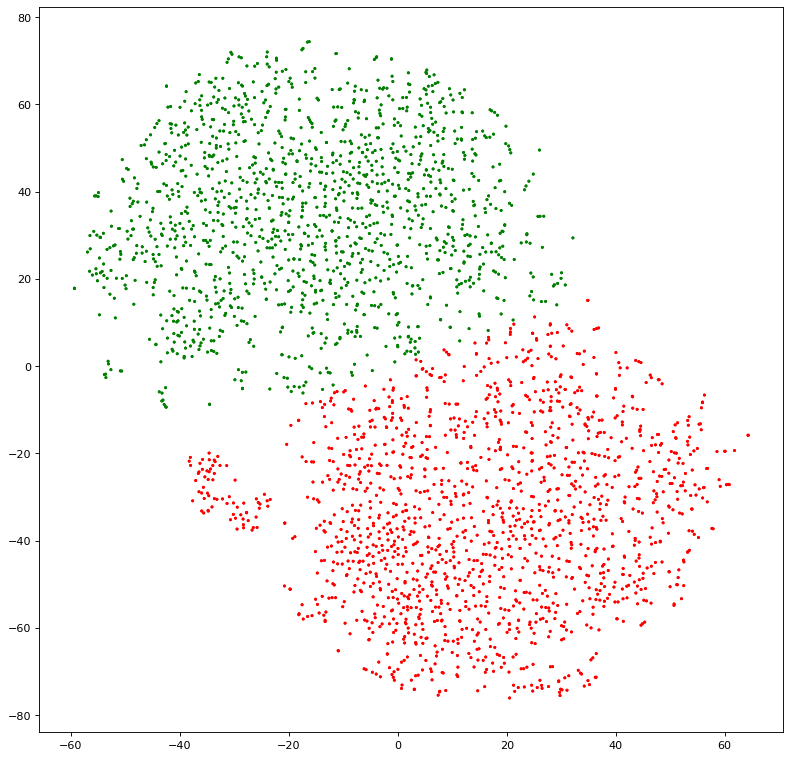

In [716]:
km = KMeans(n_clusters=2, init='random',n_init=10, max_iter=300,tol=1e-04, random_state=0)
X_km = pd.DataFrame(columns=['tsne1', 'tsne2'])
X_km['tsne1'] = fashion_pca_tsne[:, 0]
X_km['tsne2'] = fashion_pca_tsne[:, 1]

y_km = km.fit_predict(X_km)
print(y_km)

tsne_df['kmeans_label'] = y_km

colors = ['red','green']
label = y_km
red_patch = mpatches.Patch(color='red', label='0')
green_patch = mpatches.Patch(color='green', label='1')

figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
for color in colors:
    plt.scatter(X_km.iloc[:, 0],X_km.iloc[:, 1],lw=0, c=label,cmap=pcolors.ListedColormap(colors),s=7)



Distance metric for TSNE

In [0]:
def distance_metric(df):
  norms = []
  for r in np.unique(df[df.columns[2]]):
    components = df[df[df.columns[2]] == r][df.columns[:2]]
    center = components.mean()
    norms.append(np.linalg.norm(components - center))
  return sum(norms)

In [722]:
df_1 = tsne_df[tsne_df['kmeans_label']==0]
df_2 = tsne_df[tsne_df['kmeans_label']==1]
distance_metric(df_1) + distance_metric(df_2)

8231.891780853271

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


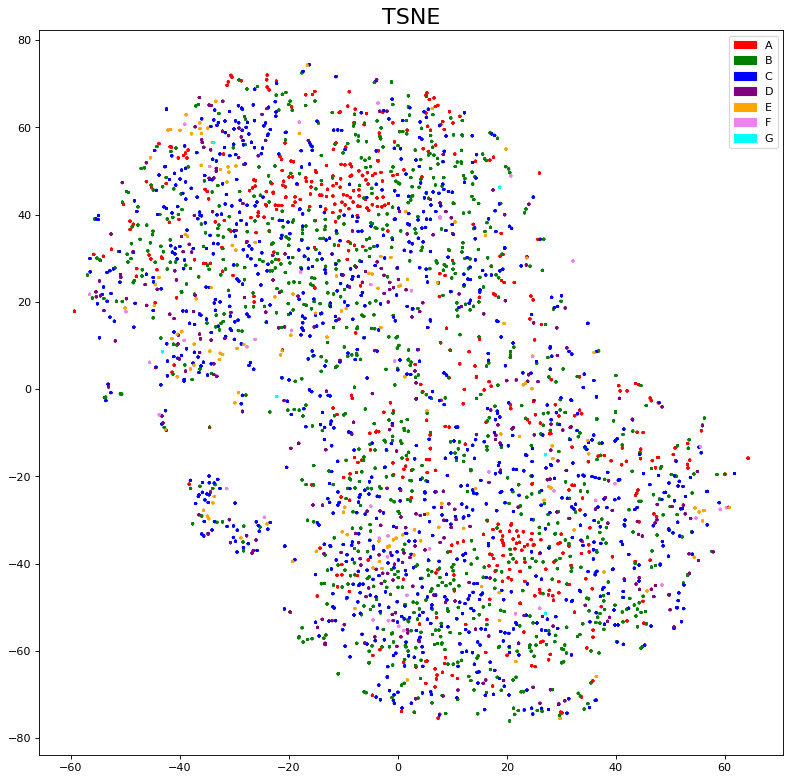

In [719]:
colors = ['red','green','blue','purple','orange','violet','cyan']
label = tsne_df.iloc[:,2]
c= [colors[i] for i in label.to_numpy()]
red_patch = mpatches.Patch(color='red', label='A')
green_patch = mpatches.Patch(color='green', label='B')
blue_patch = mpatches.Patch(color='blue', label='C')
purple_patch = mpatches.Patch(color='purple', label='D')
orange_patch = mpatches.Patch(color='orange', label='E')
violet_patch = mpatches.Patch(color='violet', label='F')
cyan_patch = mpatches.Patch(color='cyan', label='G')

figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
for color in colors:
    plt.scatter(tsne_df.iloc[:, 0], tsne_df.iloc[:, 1],lw=0, c=label,cmap=pcolors.ListedColormap(colors),s=7)
plt.title('TSNE',{'fontsize': 20})
ax = plt.subplot(111)
ax.legend(handles=[red_patch,green_patch,blue_patch,purple_patch,orange_patch,violet_patch,cyan_patch])

In [720]:
grd = tsne_df['y_subset']
grd = list(grd)
grd[1:10]
counter = Counter(grd) #to show number of grades for each grade

from math import log10, floor
def round_sig(x, sig=2):
  return round(x, sig-int(floor(log10(abs(x))))-1)

for key, value in counter.items():
    counter[key] = round_sig(value/len(y_subset))

print(counter) 
#Counter({'C': 0.34, 'B': 0.33, 'A': 0.17, 'D': 0.1, 'E': 0.045, 'F': 0.014, 'G': 0.0025})

Counter({2: 0.34, 1: 0.32, 0: 0.17, 3: 0.1, 4: 0.046, 5: 0.015, 6: 0.002})


In [721]:
#fig, ax = plt.subplots(figsize=(30,10))
data1 = pd.concat([y,X_scaled], axis=1, sort=False)
corr = data1.corr()
corr.style.background_gradient(cmap='coolwarm')
#sns.heatmap(data1.corr(), center=0, cmap='Blues')
#ax.set_title('Multi-Collinearity')

/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
